# Training the model 
https://github.com/Deci-AI/super-gradients/blob/master/notebooks/yolo_nas_custom_dataset_fine_tuning_with_qat.ipynb

In [4]:
!nvidia-smi # check for availability of GPU 

Fri Jul  5 11:13:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0  On |                  N/A |
|  0%   44C    P8    24W / 320W |    472MiB / 10240MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from super_gradients.training import models
import os 
import torch 

# Load in preexisting trained model weights. This is not the full model you can 
# run inference with, this will have to be loaded in. Example below.
HOME = os.getcwd()
mp1 = torch.load(f'{HOME}/checkpoints/vehicle_images/RUN_20240626_101822_978143/ckpt_best.pth')
# mp2 = torch.load(f'{HOME}/checkpoints2/RUN_20240626_155336_813464/ckpt_best.pth')


[2024-07-05 11:13:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/lpalombi/sg_logs/console.log


In [6]:
# Define class names in array format. These are user-defined during the annotation process. 
CLASS_NAMES = ['0']
NUM_CLASSES = len(CLASS_NAMES)

In [7]:
import torch 
# Check if GPU is available 
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
print(DEVICE)

In [8]:
# Define training parameters 
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN

train_dataset_params = dict(
    data_dir="vehicle_images",
    images_dir="",
    json_annotation_file="train.json",
    input_dim=(1920, 1088),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(1088, 1920), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(1088, 1920)),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(1088, 1920), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="vehicle_images",
    images_dir="",
    json_annotation_file="val.json",
    input_dim=(1088, 1920),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(1088, 1920), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(1088, 1920), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)
     

[2024-07-05 11:13:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Indexing dataset annotations: 100%|██████████| 441/441 [00:00<00:00, 7353.34it/s]
[2024-07-05 11:13:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [9]:
from torch.utils.data import DataLoader

NUM_WORKERS = 0
BATCH_SIZE = 1

train_dataloader_params = {
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "drop_last": True,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": BATCH_SIZE,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "num_workers": NUM_WORKERS,
    "persistent_workers": NUM_WORKERS > 0,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

In [10]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "linear_epoch_step",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 25,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}
     

In [11]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models
import os 

HOME = os.getcwd()
CHECKPOINT_DIR = f'{HOME}/please_work'

trainer = Trainer(experiment_name="vehicle_images_again", ckpt_root_dir=CHECKPOINT_DIR)
model = models.get('yolo_nas_s', num_classes=1, pretrained_weights="coco")
# trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

cuda


Indexing dataset annotations: 100%|██████████| 111/111 [00:00<00:00, 9518.09it/s]


[2024-07-05 11:13:16] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-07-05 11:13:16] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-07-05 11:13:16] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [12]:
# Testing different models 

mp1 = f'{HOME}/checkpoints/vehicle_images/RUN_20240626_101822_978143/ckpt_best.pth'
# mp2 = f'{HOME}/checkpoints2/RUN_20240626_155336_813464/ckpt_best.pth'
# mp3 = f'{HOME}/please_work/vehicle_images_again/RUN_20240627_134113_254793/ckpt_best.pth'

best_model = models.get('yolo_nas_s', num_classes=NUM_CLASSES, checkpoint_path=mp1)
# best_model2 = models.get('yolo_nas_s', num_classes=NUM_CLASSES, checkpoint_path=mp2)
# best_model3 = models.get('yolo_nas_s', num_classes=NUM_CLASSES, checkpoint_path=mp3)

# regular_metrics = trainer.test(model=best_model, test_loader=valid_loader)
# regular_metrics

[2024-07-05 11:13:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/lpalombi/Desktop/qat/checkpoints/vehicle_images/RUN_20240626_101822_978143/ckpt_best.pth EMA checkpoint.


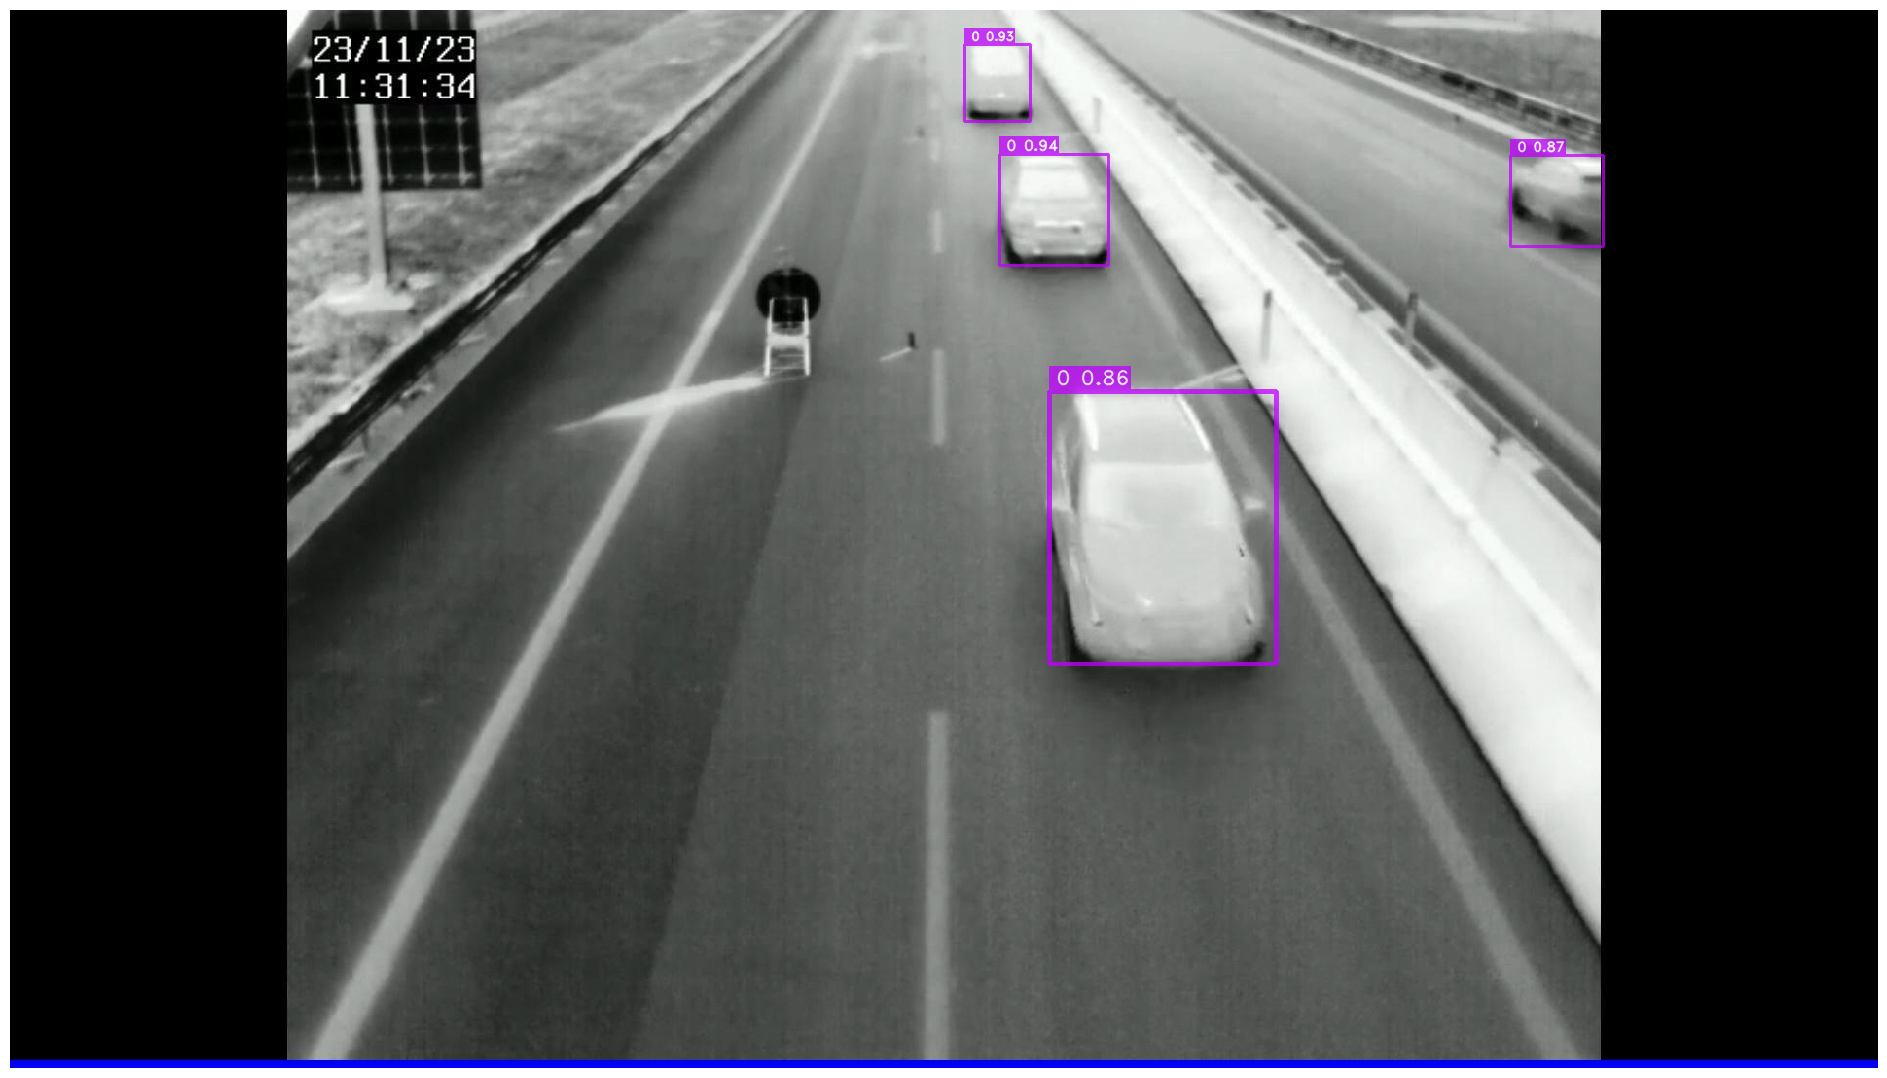

In [13]:
# Run inference on custom-trained YOLO NAS model 
prediction = best_model.predict(f'{HOME}/vehicle_images/frame_0182.jpg', fuse_model=False)
prediction.show()

# Post Training Quantization 

In [14]:
mp1_model = f'{HOME}/checkpoints/vehicle_images/RUN_20240626_101822_978143/ckpt_best.pth'

In [15]:
# Running and exporting a post-quantized model in this cell will throw an error 
# if not done in the same session as the training 
from super_gradients.conversion import ExportParams

best_model = models.get(Models.YOLO_NAS_S, num_classes=1, checkpoint_path=mp1_model)

export_params = ExportParams(batch_size=1, preprocessing=True, postprocessing=True)

ptq_result = trainer.ptq(model=best_model, calib_loader=valid_loader, valid_loader=valid_loader, export_params=export_params)

ptq_metrics = ptq_result.valid_metrics_dict

[2024-07-05 11:13:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/lpalombi/Desktop/qat/checkpoints/vehicle_images/RUN_20240626_101822_978143/ckpt_best.pth EMA checkpoint.
Testing:   0%|          | 0/111 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
prediction = ptq_result.quantized_model.predict(f'{HOME}/vehicle_images/frame_0182.jpg', fuse_model=False)
prediction.show()

In [ ]:
ptq_result.export_result

Model exported successfully to /home/lpalombi/Desktop/qat/please_work/vehicle_images_again/vehicle_images_again_1x3x1088x1920_ptq.onnx
Model expects input image of shape [1, 3, 1920, 1088]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0], device='cuda:0'))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxr

# Run inference with onnx model

In [4]:
!nvidia-smi

Tue Jul  9 09:30:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0  On |                  N/A |
| 30%   45C    P2    83W / 320W |   2255MiB / 10240MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
import onnx 
import onnxruntime
import os 

HOME = os.getcwd()

mp1 = f'{HOME}/checkpoints/vehicle_images/ptq.onnx'

session1 = onnxruntime.InferenceSession(f'{HOME}/checkpoints/vehicle_images/ptq.onnx', providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

session2 = onnxruntime.InferenceSession(f'{HOME}/yolo_nas_s/yolo_nas_s_int8.onnx', providers=["CUDAExecutionProvider", "CPUExecutionProvider"])


/home/lpalombi/Desktop/qat/checkpoints/vehicle_images/ptq.onnx


2024-07-09 16:14:11.722280025 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 1 Memcpy nodes are added to the graph torch_jit for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2024-07-09 16:14:11.914804900 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 268 Memcpy nodes are added to the graph torch_jit for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


2024-07-09 16:15:37.903236939 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 1 Memcpy nodes are added to the graph torch_jit for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


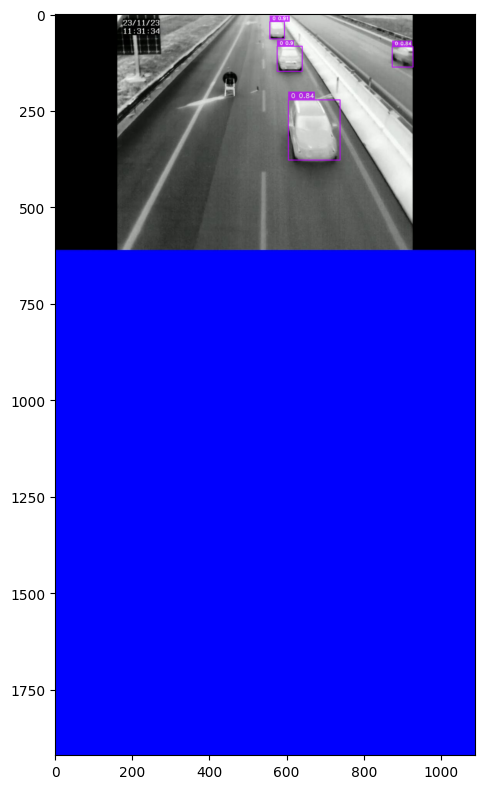

In [69]:
from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np
import cv2 

import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions=None):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=['0'], pred_boxes=predicted_boxes)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


session1 = onnxruntime.InferenceSession(f'{HOME}/checkpoints/vehicle_images/ptq.onnx', providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
# session2 = onnxruntime.InferenceSession(f'{HOME}/yolo_nas_s/yolo_nas_s_int8.onnx', providers=["CUDAExecutionProvider", "CPUExecutionProvider"])


inputs1 = [o.name for o in session1.get_inputs()]
outputs1 = [o.name for o in session1.get_outputs()]

image = load_image(f'{HOME}/padded_images/frame_0182.jpg')
image = cv2.resize(image, (1088, 1920))

input_image = np.moveaxis(image, -1, 0)
input_image = np.expand_dims(input_image, axis=0)


predictions1 = session1.run(outputs1, {inputs1[0]: input_image})
show_predictions_from_batch_format(image, predictions1)


# Convert quantized model to OpenVino IR using the command line 

In [ ]:
path = f'{HOME}/checkpoints/vehicle_images'
# !mo --input_model ptq2.onnx 

# Object detection with OpenVino IR

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

23215

In [22]:
import os
HOME = os.getcwd()
model_xml_path = f'{HOME}/checkpoints/vehicle_images/ptq.xml'

In [23]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [24]:
core = ov.Core()

model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

print(model)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("graph2_pred_boxes")
output_layer_scores = compiled_model.output("graph2_pred_scores")

<Model: 'torch_jit'
inputs[
<ConstOutput: names[input] shape[1,3,1920,1088] type: u8>
]
outputs[
<ConstOutput: names[graph2_num_predictions] shape[1,1] type: i64>,
<ConstOutput: names[graph2_pred_boxes] shape[1,..2000,4] type: f32>,
<ConstOutput: names[graph2_pred_scores] shape[1,..2000] type: f32>,
<ConstOutput: names[graph2_pred_classes] shape[1,..2000] type: i64>
]>


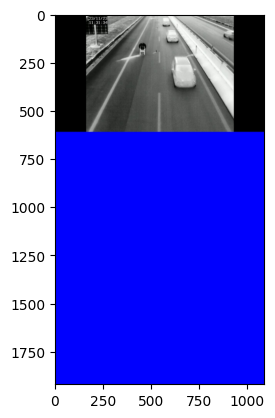

In [25]:
# Text detection models expect an image in BGR format.
image = cv2.imread(f'{HOME}/padded_images/frame_0182.jpg')
# image = cv2.imread(f'{HOME}/vehicle_images/frame_0000.jpg')

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

#Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [26]:
# Create an inference request.
pred_scores = compiled_model([input_image])[output_layer_scores]

boxes = compiled_model([input_image])[output_layer_ir]


# # Remove zero only boxes.
boxes = np.array([box for box in boxes[0] if not np.all(box == -1)])  # Assuming single batch
pred_scores = np.array([score for score in pred_scores[0] if not np.all(score == -1)])  # Assuming single batch

print(boxes)
print(pred_scores)


[[556.56647   19.815338 593.91815   64.93411 ]
 [575.0149    83.64039  640.14197  148.76582 ]
 [873.75134   84.63669  927.6216   137.60486 ]
 [604.59814  222.66678  738.36865  378.65143 ]]
[0.9052595 0.9040185 0.8367769 0.8331572]


In [27]:
# For each detection, the description is in the [x_min, y_min, x_max, y_max, conf] format:
# The image passed here is in BGR format with changed width and height. To display it in colors expected by matplotlib, use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, pred_scores, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Fetch the image shapes to calculate a ratio.
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Iterate through non-zero boxes.
    for i in range(0, len(boxes)):
        
        # Pick a confidence factor from the last place in an array.
        conf = pred_scores[i]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio.
            # If the bounding box is found at the top of the image,
            # position the upper box bar little lower to make it visible on the image.
            
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y, 10)) if idx % 2 else int(corner_position * ratio_x)) for idx, corner_position in enumerate(boxes[i])
            ]

            # Draw a box based on the position, parameters in rectangle function are: image, start_point, end_point, color, thickness.
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # Add text to the image based on position and confidence.
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type.
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

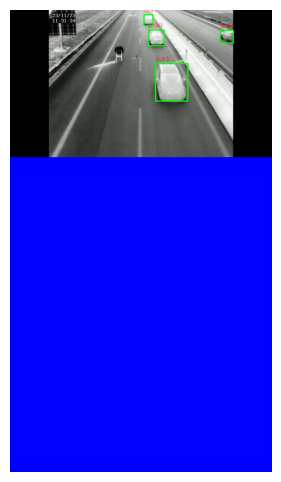

In [29]:
plt.figure(figsize=(10, 6))
plt.axis("off")
img = convert_result_to_image(resized_image, resized_image, boxes, pred_scores, conf_labels=True)
plt.imshow(img)

# New real-time test 
https://github.com/jason-li-831202/YOLO-NAS-onnxruntime/tree/master